# Applying Subtopic Ratings
<p>ADD INFOMRATION HERE</p>


___

## Step 0: Import packages and custom functions

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import itertools
from collections import Counter

import pandas as pd

In [3]:
from plottingtools import compare_to_chain
from plottingtools import compare_to_zipcode
from plottingtools import compare_to_cuisine
from plottingtools import plot_suptopic_comparisons
from plottingtools import time_marker

___

## Step 1: Import Review Data with Sub Topic Ratings

In [4]:
time_marker('Loading Restaurant Review data...')
reviews = pd.read_csv('../clean_data/az_restaurant_reviews_with_subtopics.csv', index_col=0, parse_dates=['date'], low_memory=False)

reviews.dropna(subset=['user_id'], inplace=True)

reviews.reset_index(inplace=True, drop=True)

# sanitize restaurant name text for grouping later
reviews['chain_name'] = reviews['name'].str.lower().str.replace('[^\w\s]','').str.replace(' ', '_')

time_marker('done')

[15:33:55.973172] Loading Restaurant Review data...
[15:34:06.560411] done


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495893 entries, 0 to 495892
Data columns (total 22 columns):
business_id         495893 non-null object
cool                495893 non-null int64
date                495893 non-null datetime64[ns]
funny               495893 non-null int64
review_id           495893 non-null object
stars               495893 non-null int64
text                495893 non-null object
useful              495893 non-null int64
user_id             495893 non-null object
is_fast_food        495893 non-null bool
review_len          495893 non-null int64
name                495893 non-null object
atmosphere          94385 non-null float64
value               159932 non-null float64
retention           225063 non-null float64
cleanliness         1795 non-null float64
ordering            36124 non-null float64
customer_service    285977 non-null float64
wait_time           89636 non-null float64
menu_options        12243 non-null float64
food_quality        299715

___

## Step 2: Calculate Sub Topic Ratings for Each Business
<p>Yelp Sub Topic Reviews are calculated by taking the Average of all review scores within each Sub Topic.</p>

In [6]:
# group reviews by business id
subtopic_ratings = reviews.groupby('business_id').mean()[reviews.columns[-10:-1]]
subtopic_ratings.head(3)

,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
business_id,,,,,,,,,
-050d_XIor1NpCuWkbIVaQ,4.133333,3.889908,4.118497,1.5,3.652174,4.177249,3.939577,2.857143,3.843750
-092wE7j5HZOogMLAh40zA,4.277778,3.272727,3.760000,NaN,3.250000,3.511628,3.000000,4.000000,3.051724
-0Sgh0QlUKVsWosCWJzGqQ,4.333333,1.800000,2.176471,NaN,1.448276,2.272727,1.380952,1.000000,2.050000


In [7]:
subtopic_ratings.describe()

,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
count,5814.000000,6689.000000,6841.000000,1326.000000,5442.000000,6959.000000,6248.000000,3353.000000,7024.000000
mean,3.926962,3.256184,3.343873,2.833606,2.563436,3.511395,2.918466,3.531219,3.084629
std,0.969922,0.912155,0.985701,1.559800,1.146207,0.925220,1.081782,1.261665,0.865640
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.571429,2.800000,2.750000,1.000000,1.600000,3.000000,2.047619,3.000000,2.500000
50%,4.166667,3.400000,3.545455,3.000000,2.500000,3.679739,3.000000,4.000000,3.166667
75%,4.564538,3.888889,4.040404,4.000000,3.333333,4.191675,3.740159,4.500000,3.714286
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


___

## Step 3: Import Restaurant Business Data
<p>Merge Subtopic Ratings to business information DataFrame</p>

In [8]:
time_marker('Loading Restaurant Business data...')
business_df = pd.read_csv('../clean_data/az_restaurant_business_clean.csv', index_col=0)

# sanitize restaurant name text for grouping later
business_df['chain_name'] = business_df['name'].str.lower().str.replace('[^\w\s]','').str.replace(' ', '_')

[15:34:07.519631] Loading Restaurant Business data...


In [9]:
# Merge Subtopic Ratings to Business DataFrame
restaurants = business_df.merge(subtopic_ratings, left_on='business_id', right_index=True)

In [10]:
restaurants.head(3)

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food,chain_name,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
0,777 E Thunderbird Rd Ste 107,1WBkAuQg81kokZIPMpn9Zg,"['burgers', 'restaurants']",Phoenix,1,Charr An American Burger Bar,85022.0,232,3.0,0,charr_an_american_burger_bar,3.625000,3.217391,3.440678,NaN,2.555556,3.645669,2.425532,5.00,2.661765
1,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"['restaurants', 'pizza']",Mesa,1,Little Caesars Pizza,85209.0,4,2.5,0,little_caesars_pizza,NaN,3.000000,2.000000,NaN,2.000000,2.666667,2.000000,NaN,2.666667
2,8140 N Hayden Rd Ste H115,VdlPZg2NAu8t8GkdbPLecg,"['restaurants', 'gluten-free', 'indian', 'seaf...",Scottsdale,1,Tandoori Times Indian Bistro,85258.0,263,3.5,0,tandoori_times_indian_bistro,3.489796,3.367647,3.643678,NaN,2.600000,3.631206,2.837209,3.25,3.223684


___

## Step 4: Plotting Subtopic Review Stars against Restaurant Star Ratings
<p>Restarants are given a single Star Rating when Users write a review, these ratings are compared to our calculated Rating for each of the 9 identified Sub Topics.</p>


### Step 4.1: Plot Star Comparisons for All Restaurants

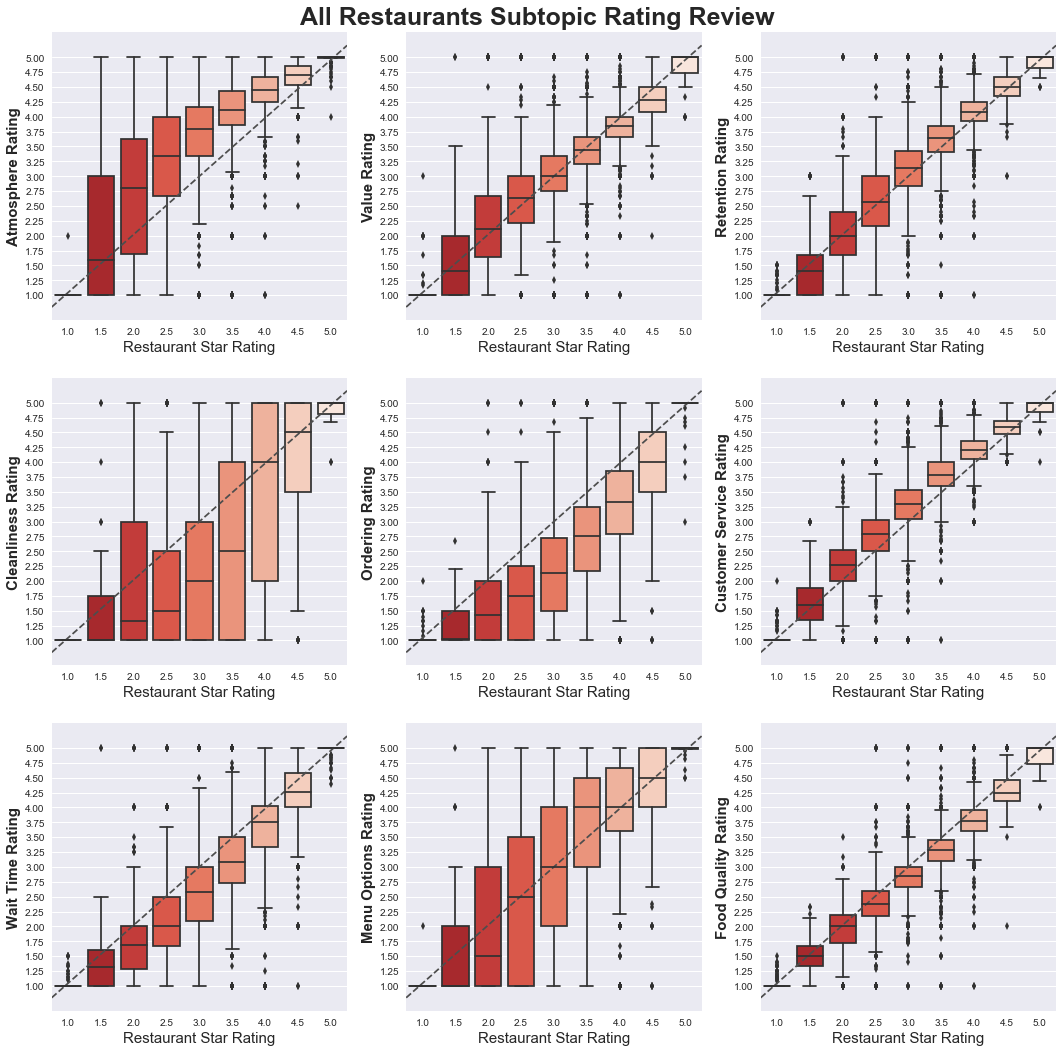

In [11]:
plot_suptopic_comparisons(restaurants, palette='Reds_r', title_prefix='All Restaurants')

### Step 4.2: Plot Star Comparisons for Non Fast Food Restaurants

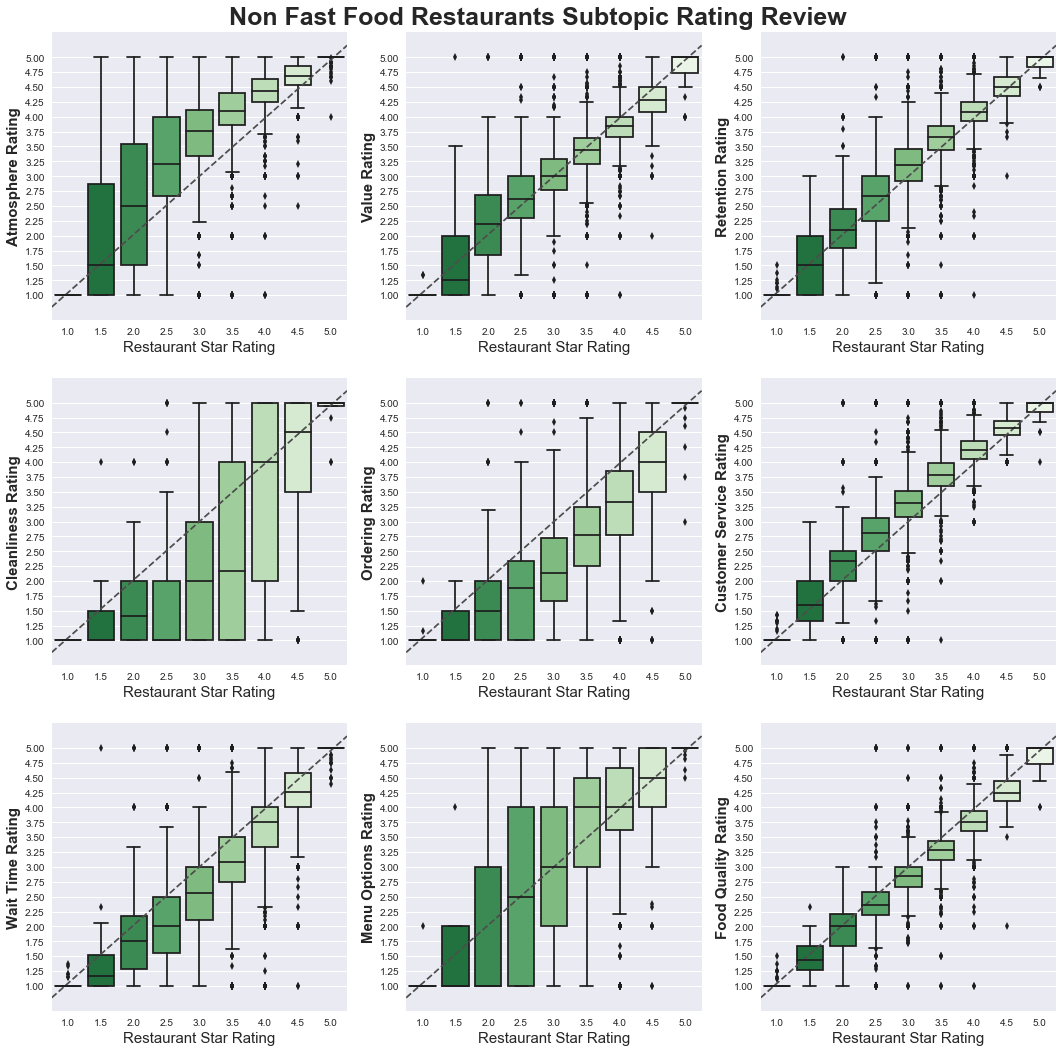

In [12]:
plot_suptopic_comparisons(restaurants[restaurants.is_fast_food == 0], palette='Greens_r', 
                          title_prefix='Non Fast Food Restaurants', show=True)

### Step 4.3: Plot Star Comparisons for Fast Food Restaurants

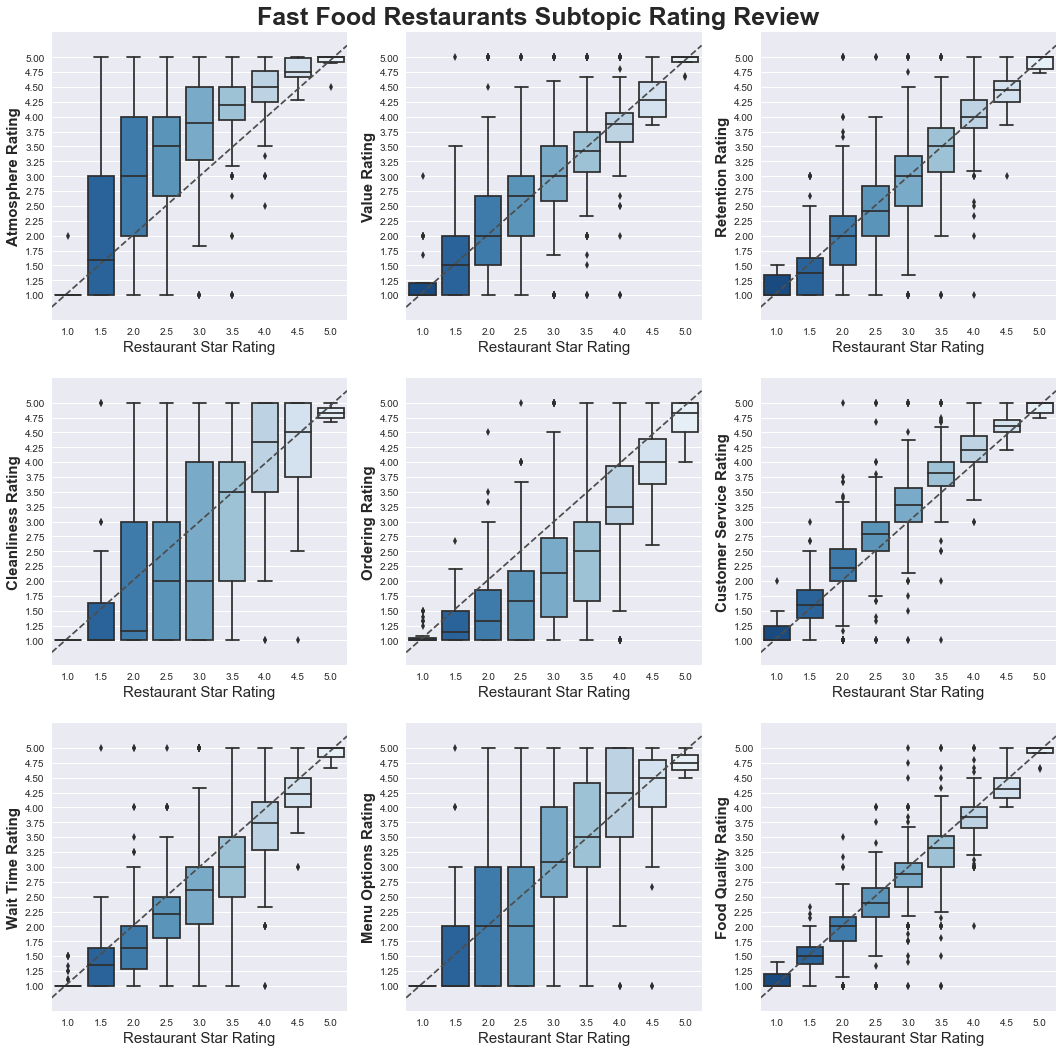

In [13]:
plot_suptopic_comparisons(restaurants[restaurants.is_fast_food == 1], palette='Blues_r',
                          title_prefix='Fast Food Restaurants', show=True)

___

## Step 5: Select Sample Restaurants to Generate Reports

<ul>
    <li><b>ff_sample_bid:</b> select Fast Food Chain that has the most locations, then select location with median number of reviews</li>
    <li><b>nff_sample_bid:</b> select Non Fast Food Chain that has the most locations, then select location with median number of reviews</li>
</ul>

In [14]:
def get_top_n_chains(n, ff=''):

    if ff == 'ff':
        top_n_chains = [x[0] for x in Counter(restaurants[restaurants.is_fast_food == 1].chain_name).most_common(n)]
    elif ff == 'nff':
        top_n_chains = [x[0] for x in Counter(restaurants[restaurants.is_fast_food == 0].chain_name).most_common(n)]
    else:
        top_n_chains = [x[0] for x in Counter(restaurants.chain_name).most_common(n)]
        
    # extract business_id values of all retaurants in top_ten_chains
    top_n_chain_bids = list(reviews[reviews.chain_name.isin(top_n_chains)].business_id.unique())

    
    if ff == 'ff':
        print('Working with reviews for {:d} Fast Food Restaurants across {:d} Chains      {}'.format(len(top_n_chain_bids), n, top_n_chains))
    elif ff == 'nff':
        print('Working with reviews for {:d} Non Fast Food Restaurants across {:d} Chains  {}'.format(len(top_n_chain_bids), n, top_n_chains))
    else:
        print('Working with reviews for {:d} Restaurants across {:d} Chains                {}'.format(len(top_n_chain_bids), n, top_n_chains))
    
    return top_n_chain_bids

In [15]:
def get_bid_most_reviewed(df):
    bid = df.groupby('business_id').count()['name'][df.groupby('business_id').count()['name'] == df.groupby('business_id').count()['name'].max()].index[0]
    return bid

In [16]:
top_n_chains = 1

ff_chain_bids = get_top_n_chains(top_n_chains, ff='ff')
ff_chain_reviews = reviews[reviews.business_id.isin(ff_chain_bids)]
ff_sample_bid = get_bid_most_reviewed(ff_chain_reviews)
print('Selected "{}" as a sample Fast Food Location'.format(ff_sample_bid))

print()

nff_chain_bids = get_top_n_chains(top_n_chains, ff='nff')
nff_chain_reviews = reviews[reviews.business_id.isin(nff_chain_bids)]
nff_sample_bid = get_bid_most_reviewed(nff_chain_reviews)
print('Selected "{}" as a sample Non Fast Food Location'.format(nff_sample_bid))


Working with reviews for 235 Fast Food Restaurants across 1 Chains      ['subway']
Selected "Gfa85o6JuT9uBqi9fqC-UA" as a sample Fast Food Location

Working with reviews for 58 Non Fast Food Restaurants across 1 Chains  ['filibertos_mexican_food']
Selected "QMaaLfedGzNhHz6PZKAUkw" as a sample Non Fast Food Location


___

## Step 6:  Compare Restaurant to Others in the same Chain
<p>Given a `business_id` this report shows the status of the given business in comparison to others bearing the same name.</p>

### Step 6.1: Plot Chain Comparisons for Non Fast Food Sample Restaurant

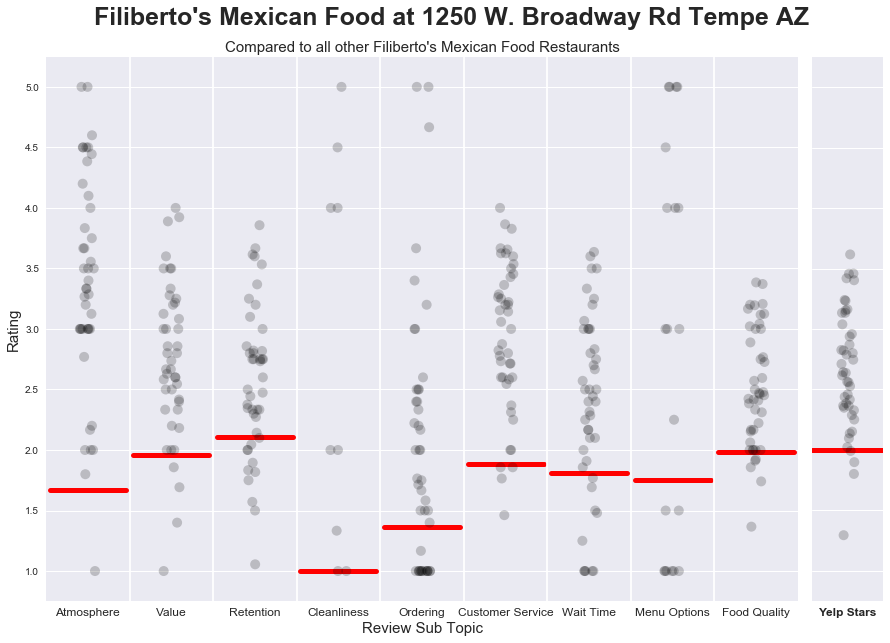

'../charts/reports/filibertosmexicanfood_QMaaLfedGzNhHz6PZKAUkw_chain_comparison.png'

In [17]:
compare_to_chain(reviews, nff_sample_bid, biz_subtopics=restaurants, show=True)

### Step 6.2: Plot Chain Comparisons for Fast Food Sample Restaurant

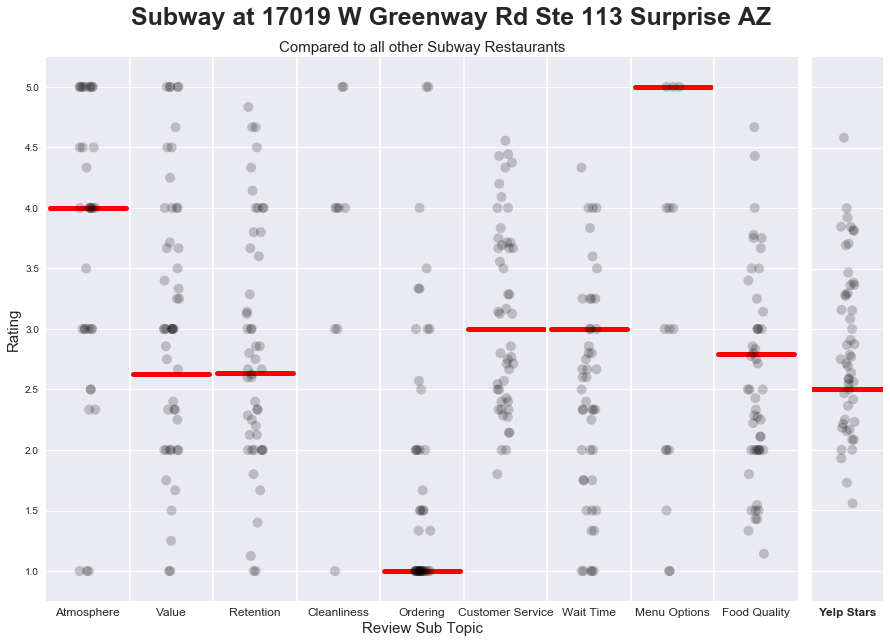

'../charts/reports/subway_Gfa85o6JuT9uBqi9fqC-UA_chain_comparison.png'

In [18]:
compare_to_chain(reviews, ff_sample_bid, biz_subtopics=restaurants, show=True)

___
## Step 7:  Compare Restaurant to Others in the same Zip Code
<p>Given a `business_id` this report shows the status of the given business in comparison to other Restaurants in the same Zip Code.</p>

### Step 7.1: Plot Zip Code Comparisons for Non Fast Food Sample Restaurant

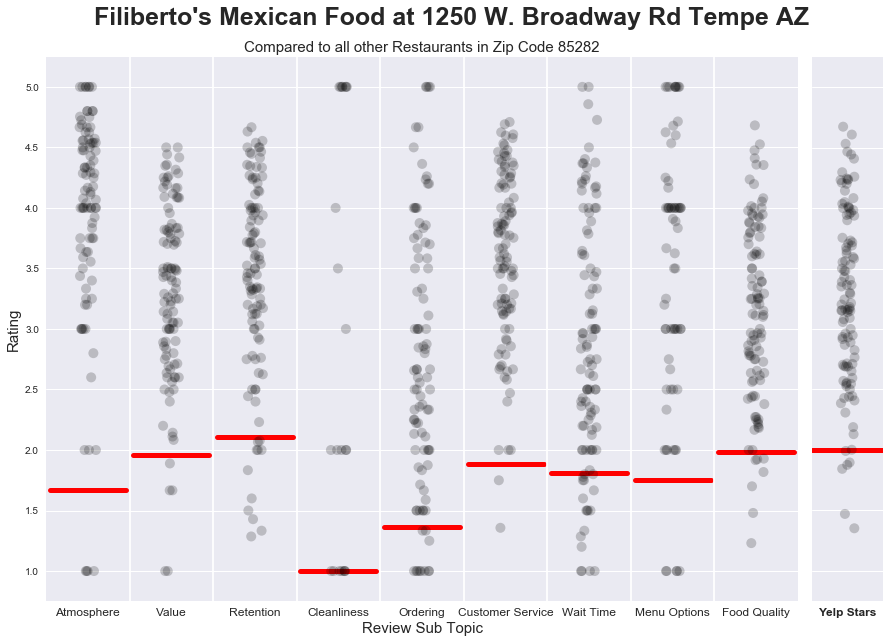

'../charts/reports/filibertosmexicanfood_QMaaLfedGzNhHz6PZKAUkw_zipcode_comparison.png'

In [19]:
compare_to_zipcode(reviews, nff_sample_bid, biz_subtopics=restaurants, show=True)

### Step 7.2: Plot Zip Code Comparisons for Fast Food Sample Restaurant

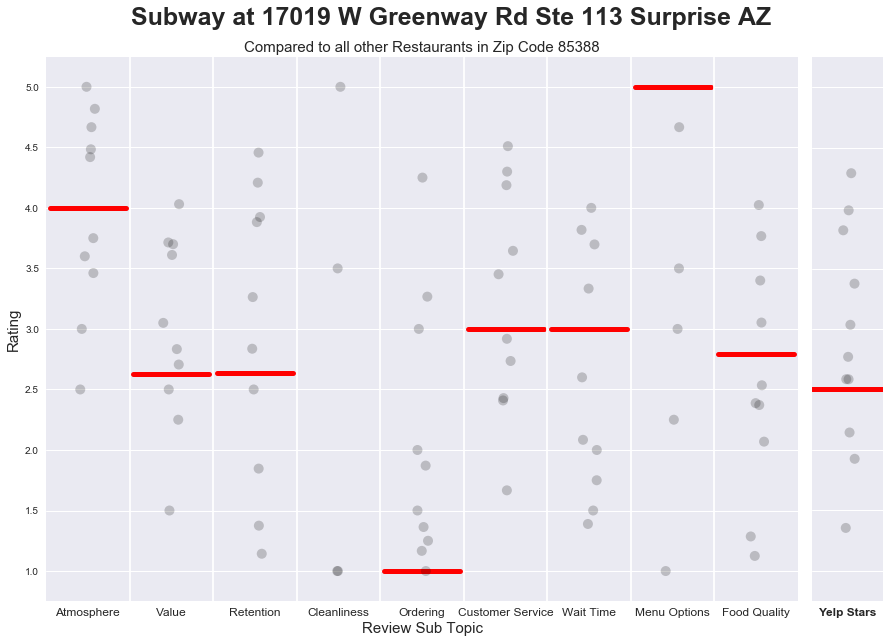

'../charts/reports/subway_Gfa85o6JuT9uBqi9fqC-UA_zipcode_comparison.png'

In [20]:
compare_to_zipcode(reviews, ff_sample_bid, biz_subtopics=restaurants, show=True)

___
## Step 8:  Compare Restaurant to Others Serving the Same Cuisine
<p>Given a `business_id` this report shows the status of the given business in comparison to other Restaurants serving the same Cuisines.</p>

<p>Cuisines are derived from the `restaurants` category column</p>

In [21]:
def get_restaurant_cuisines(df, bid, ignore_list=['restaurants', 'fast_food']):

    bid_cats = df[df.business_id == bid]['categories'].to_frame()['categories'].values
    bid_cats = bid_cats[0].split("'")[1::2]
    
    bid_cats = [x for x in bid_cats if x not in ignore_list]
    return bid_cats

In [22]:
def plot_cuisine_comparisons(bid, show=True):
    
    # get cuisines served at restaurant
    cuisines = get_restaurant_cuisines(restaurants, bid)
    
    for cuisine in cuisines:
        compare_to_cuisine(reviews, cuisine, bid, reviews, min_reviews=10, biz_subtopics=restaurants, min_biz=5, show=show)
        compare_to_cuisine(reviews[reviews.is_fast_food == 1], cuisine, bid, reviews, biz_subtopics=restaurants, min_reviews=10, min_biz=5, show=show, file_suffix='ff')
        compare_to_cuisine(reviews[reviews.is_fast_food == 0], cuisine, bid, reviews, biz_subtopics=restaurants, min_reviews=10, min_biz=5, show=show, file_suffix='nff')

### Step 8.1: Plot Cuisine Comparisons for Non Fast Food Sample Restaurant

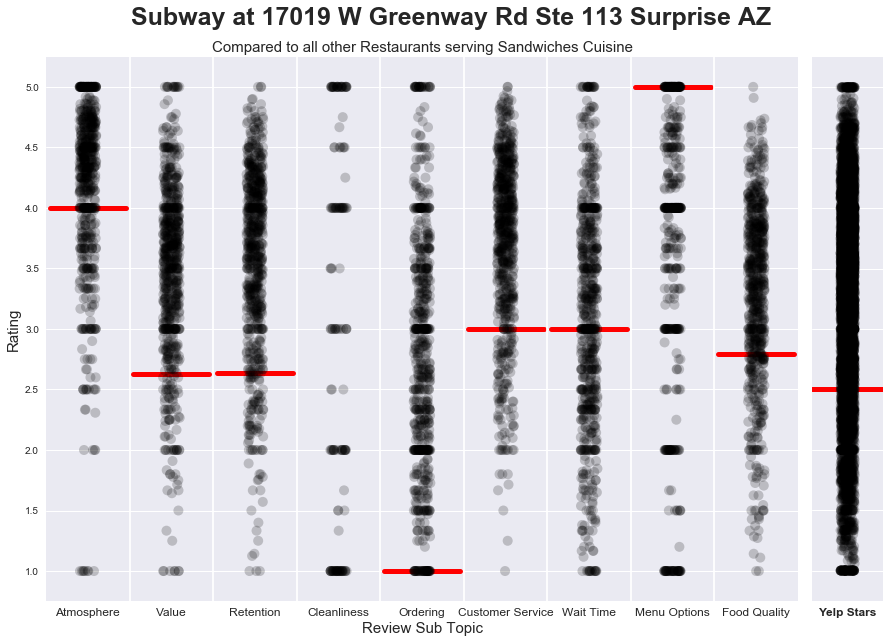

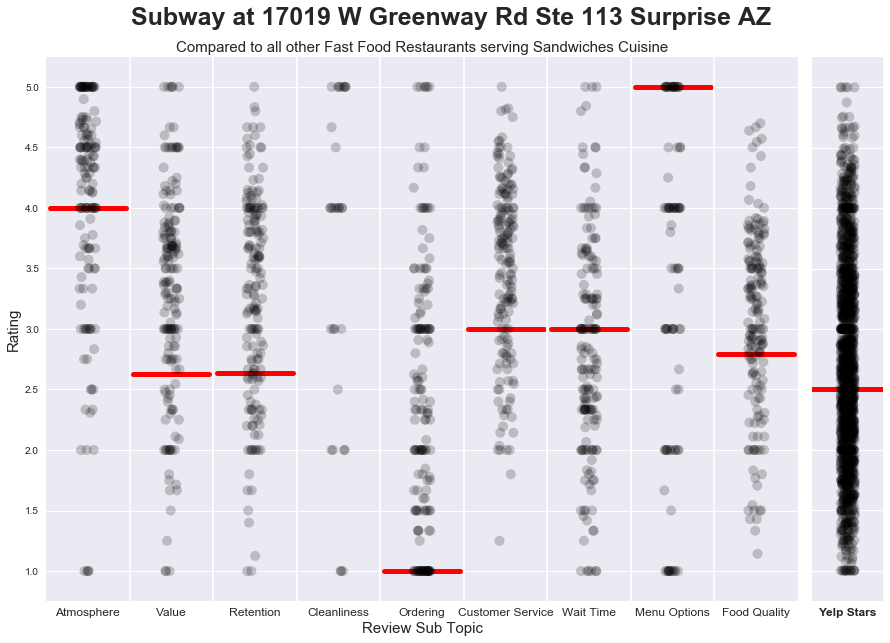

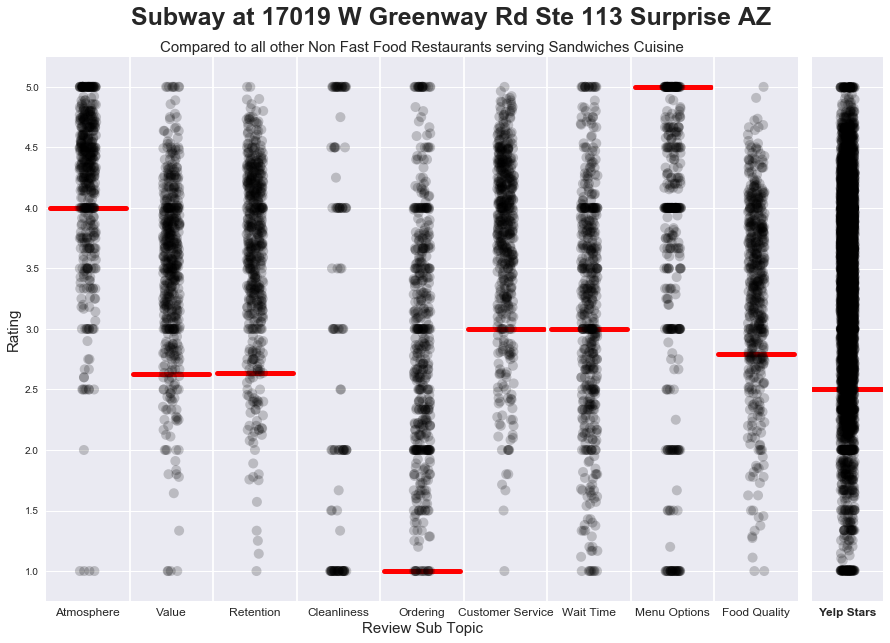

In [23]:
plot_cuisine_comparisons(ff_sample_bid, show=True)

### Step 8.2: Plot Cuisine Comparisons for Fast Food Sample Restaurant

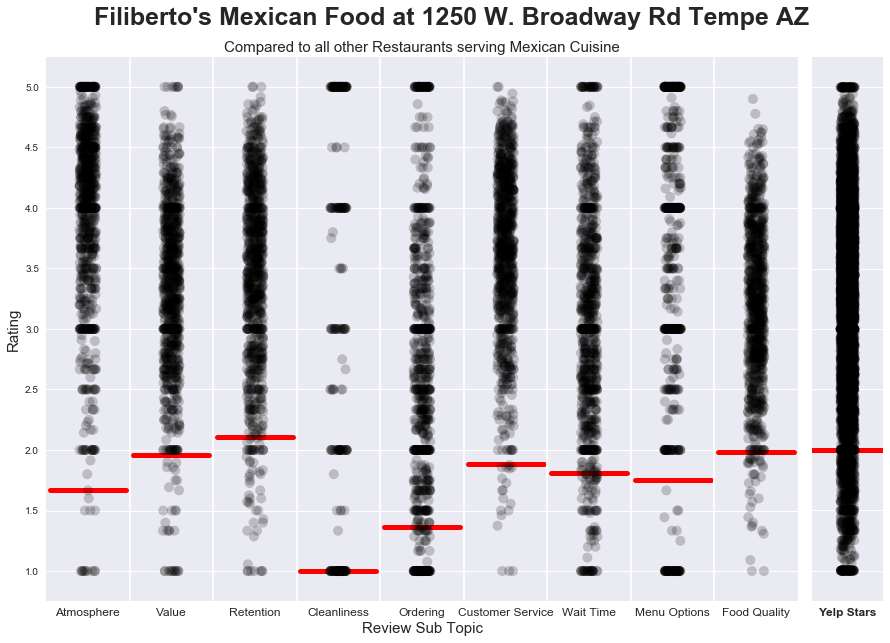

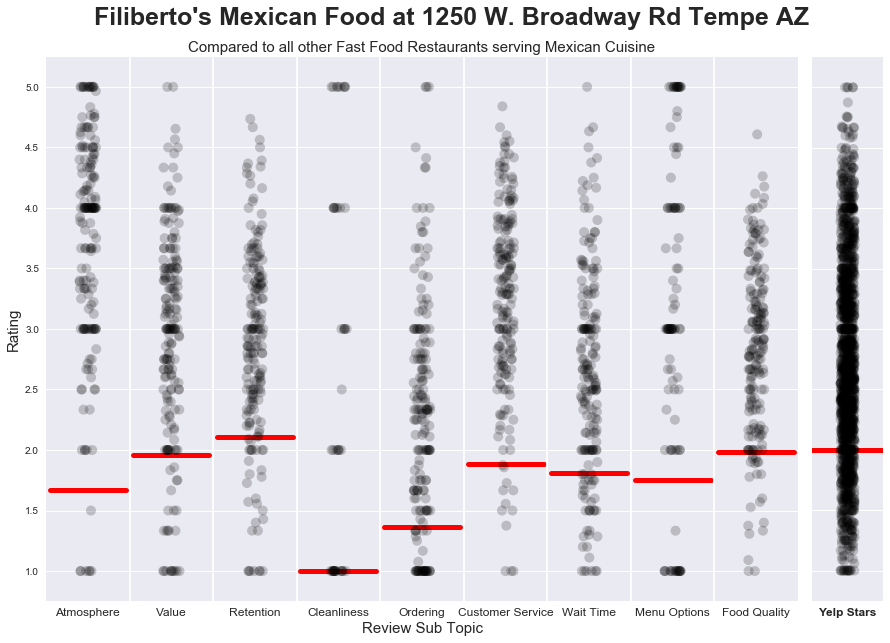

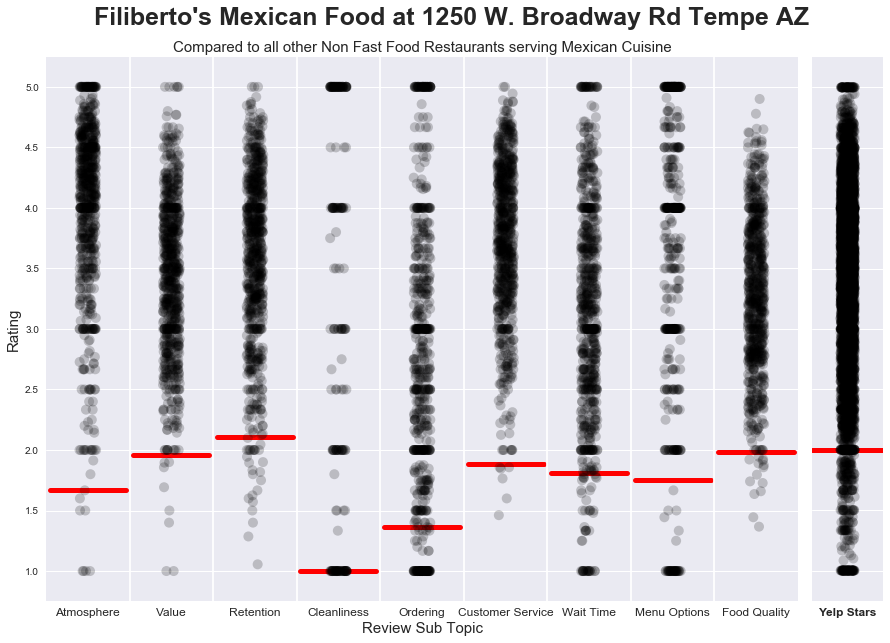

In [24]:
plot_cuisine_comparisons(nff_sample_bid, show=True)

___

## Step 9: Restaurant with 'Official' Sub Topic Stars
<p>Yelp Calculates Business Stars by taking the mean of all reviews and rounding the `stars` up to the nearest one half star.  We will do the same for each of our Sub Topic Stars.</p>

In [25]:
from plottingtools import print_restaurant_summary

In [26]:
print_restaurant_summary(restaurants, ff_sample_bid)

Address           17019 W Greenway Rd Ste 113
Business Id       Gfa85o6JuT9uBqi9fqC-UA
Categories        ['restaurants', 'sandwiches', 'fast_food']
City              Surprise
Is Open           1
Name              Subway
Postal Code       85388.0
Review Count      27
Stars             2.5
Is Fast Food      1
Chain Name        subway
Atmosphere        4.0
Value             2.75
Retention         2.75
Cleanliness       nan
Ordering          1.0
Customer Service  3.0
Wait Time         3.0
Menu Options      5.0
Food Quality      3.0


In [27]:
print_restaurant_summary(restaurants, nff_sample_bid)

Address           1250 W. Broadway Rd
Business Id       QMaaLfedGzNhHz6PZKAUkw
Categories        ['restaurants', 'mexican']
City              Tempe
Is Open           1
Name              Filiberto's Mexican Food
Postal Code       85282.0
Review Count      101
Stars             2.0
Is Fast Food      0
Chain Name        filibertos_mexican_food
Atmosphere        1.75
Value             2.0
Retention         2.25
Cleanliness       1.0
Ordering          1.5
Customer Service  2.0
Wait Time         2.0
Menu Options      1.75
Food Quality      2.0
